In [1]:
pip install --upgrade git+https://github.com/keras-team/keras-cv

  Cloning https://github.com/keras-team/keras-cv to c:\users\maxko\appdata\local\temp\pip-req-build-pq3brh4f
  Resolved https://github.com/keras-team/keras-cv to commit 96c3de8669affa0fc059a5be867654dc4239cda9
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-cv 'C:\Users\maxko\AppData\Local\Temp\pip-req-build-pq3brh4f'


In [2]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import visualization

from scipy.spatial.distance import cdist

SPLIT_RATIO = 0.2
BATCH_SIZE = 1
LEARNING_RATE = 0.01
EPOCH = 20
GLOBAL_CLIPNORM = 5.0

c:\Users\maxko\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Тестовые данные


In [3]:
class_ids = [
    "oil"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

path_images = r"C:\DIPLOM\Данные на диск\test\images"

path_annot = r"C:\DIPLOM\Данные на диск\test\labels"


xml_files_test = sorted([
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".XML")
    ])


jpg_files_test = sorted([
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ])

# с дозаполнением сущесвующими данными 

def parse_annotation(xml_file, image_size):
    # Проверяем существование файла
    if not os.path.exists(xml_file):
        print(f"XML file '{xml_file}' does not exist.")
        return None, None, None

    # Открываем XML-файл для чтения
    with open(xml_file, 'r') as f:
        lines = f.readlines()  # Считываем строки из файла

    # Получаем путь к изображению из имени файла
    image_name = os.path.splitext(os.path.basename(xml_file))[0] + '.jpg'
    image_path = os.path.join(path_images, image_name)

    # Обрабатываем каждую строку файла
    boxes = []
    classes = []
    for line in lines:
        line_data = line.strip().split(' ')  # Разделяем строку по пробелам
        class_id = int(line_data[0])  # Первое значение - идентификатор класса
        box_data = list(map(float, line_data[1:]))  # Остальные значения - координаты ограничивающего прямоугольника

        # Преобразуем координаты из диапазона от 0 до 1 в диапазон от 0 до 650
        box_data = [coord * image_size for coord in box_data]

        # Добавляем координаты и идентификатор класса в списки
        classes.append(class_id)
        boxes.append(box_data)

    return image_path, boxes, classes

# Создаем списки для хранения путей к изображениям, координат и идентификаторов классов
image_paths = []
bbox = []
classes = []

# Обрабатываем каждый XML-файл
for xml_file in tqdm(xml_files_test):
    image_path, boxes, class_ids = parse_annotation(xml_file, image_size=640)
    if image_path is not None and boxes is not None and class_ids is not None:
        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)

bbox_tensor = tf.ragged.constant(bbox)
classes_tensor = tf.ragged.constant(classes)
image_paths_tensor = tf.ragged.constant(image_paths)

data_test = tf.data.Dataset.from_tensor_slices((image_paths, classes_tensor, bbox_tensor))

# Determine the number of validation samples
num_test= int(len(xml_files_test))
test_data = data_test.take(num_test)


  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 148.16it/s]


Тренировочные данне


In [4]:
# import yaml

# train_path_images = r"C:\DIPLOM\Данные на диск\train\images"
# train_path_annot = r"C:\DIPLOM\Диплом\Данные на диск\train\labels"
# val_path_images = r"C:\DIPLOM\Диплом\Данные на диск\valid\images"
# val_path_annot = r"C:\DIPLOM\Данные на диск\valid\labels"

# def parse_annotation(xml_files, path_images, path_annot):
#     data = []
#     for xml_file in xml_files:
#         image_name = os.path.splitext(os.path.basename(xml_file))[0] + '.jpg'
#         image_path = os.path.join(path_images, image_name)
#         with open(xml_file, 'r') as f:
#             lines = f.readlines()
#         boxes = []
#         classes = []
#         for line in lines:
#             line_data = line.strip().split(' ')
#             class_id = int(line_data[0])
#             box_data = list(map(float, line_data[1:]))
#             boxes.append(box_data)
#             classes.append(class_id)
#         data.append({"image_path": image_path, "bounding_boxes": boxes, "classes": classes})
#     return data

# train_xml_files = sorted([
#     os.path.join(train_path_annot, file_name)
#     for file_name in os.listdir(train_path_annot)
#     if file_name.endswith(".xml")
# ])

# val_xml_files = sorted([
#     os.path.join(val_path_annot, file_name)
#     for file_name in os.listdir(val_path_annot)
#     if file_name.endswith(".xml")
# ])

# train_data = parse_annotation(train_xml_files, train_path_images, train_path_annot)
# val_data = parse_annotation(val_xml_files, val_path_images, val_path_annot)

# yaml_file_path = r"C:\DIPLOM\Диплом\Data.yaml"
# with open(yaml_file_path, 'w') as yaml_file:
#     yaml.dump({"train": train_data, "val": val_data}, yaml_file)

# print("Данные успешно записаны в файл YAML:", yaml_file_path)


In [5]:
class_ids = [
    "oil"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

path_images = r"C:\DIPLOM\Данные на диск\train\images"

path_annot = r"C:\DIPLOM\Данные на диск\train\labels"


xml_files = sorted([
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith("5cb1309808f3d9be408b4567_jpg.rf.4b748d9127cefaed6647760639564714.xml")
    ])


jpg_files = sorted([
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith("5cb1309808f3d9be408b4567_jpg.rf.4b748d9127cefaed6647760639564714.jpg")
    ])



Поиск максимального количесва ограничивающих рамок


In [6]:
import os

def find_max_lines_in_xml_files(xml_files):
    max_lines = 0
    for xml_file in xml_files:
        # Проверяем существование файла
        if not os.path.exists(xml_file):
            print(f"XML file '{xml_file}' does not exist.")
            continue
        
        # Открываем XML-файл для чтения
        with open(xml_file, 'r') as f:
            lines = f.readlines()  # Считываем строки из файла
        
        # Обновляем значение максимального количества строк
        max_lines = max(max_lines, len(lines))
    
    return max_lines

# Найдем максимальное количество строк в XML-файлах
max_lines = find_max_lines_in_xml_files(xml_files)
print("Максимальное количество строк в XML-файлах:", max_lines)


Максимальное количество строк в XML-файлах: 6


Приведение данных к тензоров единого размера Тренировочные двнные


In [7]:
# с дозаполнением сущесвующими данными 

def parse_annotation(xml_file, image_size):
    # Проверяем существование файла
    if not os.path.exists(xml_file):
        print(f"XML file '{xml_file}' does not exist.")
        return None, None, None

    # Открываем XML-файл для чтения
    with open(xml_file, 'r') as f:
        lines = f.readlines()  # Считываем строки из файла

    # Получаем путь к изображению из имени файла
    image_name = os.path.splitext(os.path.basename(xml_file))[0] + '.jpg'
    image_path = os.path.join(path_images, image_name)

    # Обрабатываем каждую строку файла
    boxes = []
    classes = []
    for line in lines:
        line_data = line.strip().split(' ')  # Разделяем строку по пробелам
        class_id = int(line_data[0])  # Первое значение - идентификатор класса
        box_data = list(map(float, line_data[1:]))  # Остальные значения - координаты ограничивающего прямоугольника

        # Преобразуем координаты из диапазона от 0 до 1 в диапазон от 0 до 650
        box_data = [coord * image_size for coord in box_data]

        # Добавляем координаты и идентификатор класса в списки
        classes.append(class_id)
        boxes.append(box_data)

    # Повторяем уже существующие координаты до длины 10
    while len(boxes) < max_lines:
        boxes.extend(boxes[:max_lines - len(boxes)])
        classes.extend(classes[:max_lines - len(classes)])

    # Обрезаем лишние координаты и идентификаторы классов до длины 10
    bbox_padded = boxes[:max_lines]
    classes_padded = classes[:max_lines]

    return image_path, bbox_padded, classes_padded

# Создаем списки для хранения путей к изображениям, координат и идентификаторов классов
image_paths = []
bbox = []
classes = []

# Обрабатываем каждый XML-файл
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file, image_size=640)
    if image_path is not None and boxes is not None and class_ids is not None:
        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)

bbox_tensor = tf.ragged.constant(bbox)
classes_tensor = tf.ragged.constant(classes)
image_paths_tensor = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes_tensor, bbox_tensor))


100%|██████████| 1/1 [00:00<00:00, 1004.38it/s]


Считывание валидационных данных


In [8]:
class_ids = [
    "oil"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

path_images = r"C:\DIPLOM\Данные на диск\valid\images"

path_annot = r"C:\DIPLOM\Данные на диск\valid\labels"

xml_files_val = sorted([
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".XML")
    ])


jpg_files_val = sorted([
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ])

Поиск максимумва валидационных данных


In [9]:
import os

def find_max_lines_in_xml_files(xml_files):
    max_lines = 0
    for xml_file in xml_files:
        # Проверяем существование файла
        if not os.path.exists(xml_file):
            print(f"XML file '{xml_file}' does not exist.")
            continue
        
        # Открываем XML-файл для чтения
        with open(xml_file, 'r') as f:
            lines = f.readlines()  # Считываем строки из файла
        
        # Обновляем значение максимального количества строк
        max_lines = max(max_lines, len(lines))
    
    return max_lines

# Найдем максимальное количество строк в XML-файлах
max_lines_val = find_max_lines_in_xml_files(xml_files_val)
print("Максимальное количество строк в XML-файлах:", max_lines_val)


Максимальное количество строк в XML-файлах: 4


In [10]:
# с дозаполнением сущесвующими данными 

def parse_annotation(xml_file, image_size):
    # Проверяем существование файла
    if not os.path.exists(xml_file):
        print(f"XML file '{xml_file}' does not exist.")
        return None, None, None

    # Открываем XML-файл для чтения
    with open(xml_file, 'r') as f:
        lines = f.readlines()  # Считываем строки из файла

    # Получаем путь к изображению из имени файла
    image_name = os.path.splitext(os.path.basename(xml_file))[0] + '.jpg'
    image_path = os.path.join(path_images, image_name)

    # Обрабатываем каждую строку файла
    boxes = []
    classes = []
    for line in lines:
        line_data = line.strip().split(' ')  # Разделяем строку по пробелам
        class_id = int(line_data[0])  # Первое значение - идентификатор класса
        box_data = list(map(float, line_data[1:]))  # Остальные значения - координаты ограничивающего прямоугольника

        # Преобразуем координаты из диапазона от 0 до 1 в диапазон от 0 до 650
        box_data = [coord * image_size for coord in box_data]

        # Добавляем координаты и идентификатор класса в списки
        classes.append(class_id)
        boxes.append(box_data)

    # Повторяем уже существующие координаты до длины 10
    while len(boxes) < max_lines_val:
        boxes.extend(boxes[:max_lines_val - len(boxes)])
        classes.extend(classes[:max_lines_val - len(classes)])

    # Обрезаем лишние координаты и идентификаторы классов до длины 10
    bbox_padded = boxes[:max_lines_val]
    classes_padded = classes[:max_lines_val]

    return image_path, bbox_padded, classes_padded

# Создаем списки для хранения путей к изображениям, координат и идентификаторов классов
image_paths = []
bbox = []
classes = []

# Обрабатываем каждый XML-файл
for xml_file in tqdm(xml_files_val):
    image_path, boxes, class_ids = parse_annotation(xml_file, image_size=640)
    if image_path is not None and boxes is not None and class_ids is not None:
        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)

bbox_tensor = tf.ragged.constant(bbox)
classes_tensor = tf.ragged.constant(classes)
image_paths_tensor = tf.ragged.constant(image_paths)

data_val = tf.data.Dataset.from_tensor_slices((image_paths, classes_tensor, bbox_tensor))


100%|██████████| 86/86 [00:00<00:00, 5732.93it/s]


In [11]:
# Determine the number of validation samples
num_train = int(len(xml_files))# * SPLIT_RATIO)
num_valid = int(len(xml_files_val))
num_test= int(len(xml_files_test))

# Split the dataset into train and validation sets
val_data = data_val.take(num_valid)
train_data = data.take(num_train)
test_data = data_test.take(num_test)

batch = 64
num_boxes = 10

Подготовка данных к визуализации


In [12]:
def convert_cxcywh_to_xywh(bbox_cxcywh):
    bbox_cx, bbox_cy, bbox_w, bbox_h = tf.split(bbox_cxcywh, 4, axis=-1)
    
    bbox_xmin = bbox_cx - bbox_w / 2.0
    bbox_ymin = bbox_cy - bbox_h / 2.0
    bbox_xmax = bbox_cx + bbox_w / 2.0
    bbox_ymax = bbox_cy + bbox_h / 2.0
    
    bbox_xywh = tf.concat([bbox_xmin, bbox_ymin, bbox_w, bbox_h], axis=-1)
    return bbox_xywh

target_width = 640
target_height = 640

def load_image(image_path, target_width, target_height):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [target_height, target_width])
    return image

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path, target_width, target_height)
    
    # Convert bounding boxes to cxcywh format
    bbox_cxcywh = convert_cxcywh_to_xywh(bbox.to_tensor())
    
    # Create a dictionary for bounding boxes
    bounding_boxes = {
        "classes": classes,
        "boxes": bbox_cxcywh,  
    }
    
    # Combine image and bounding boxes into a dictionary
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


Визуализация


Image shape: (1, 640, 640, 3)
Inputs: {'classes': <tf.RaggedTensor [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]>, 'boxes': <tf.RaggedTensor [[[0.0, 0.0, 80.0, 320.0],
  [99.0, 0.0, 176.0, 162.0],
  [275.0, 238.0, 247.0, 82.0],
  [0.0, 320.0, 275.0, 320.0],
  [288.0, 445.0, 352.0, 195.0],
  [577.0, 320.0, 63.0, 111.0]]]>}
Image shape: (1, 640, 640, 3)
Inputs: {'classes': <tf.RaggedTensor [[0.0, 0.0, 0.0, 0.0]]>, 'boxes': <tf.RaggedTensor [[[3.0, 340.0, 637.0, 300.0],
  [3.0, 340.0, 637.0, 300.0],
  [3.0, 340.0, 637.0, 300.0],
  [3.0, 340.0, 637.0, 300.0]]]>}
Image shape: (1, 640, 640, 3)
Inputs: {'classes': <tf.RaggedTensor [[0.0]]>, 'boxes': <tf.RaggedTensor [[[329.0, 184.75, 311.0, 447.5]]]>}


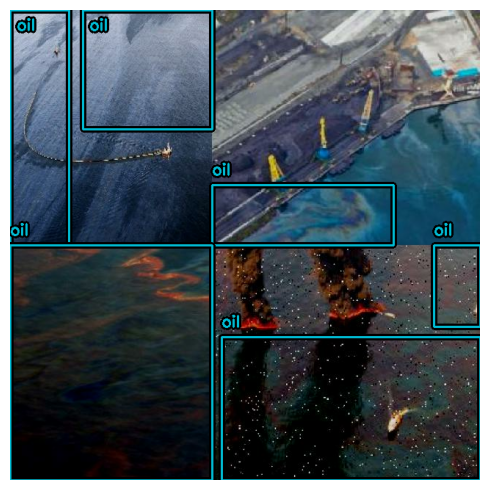

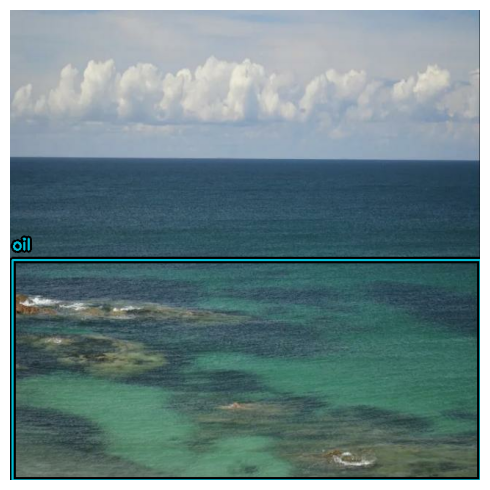

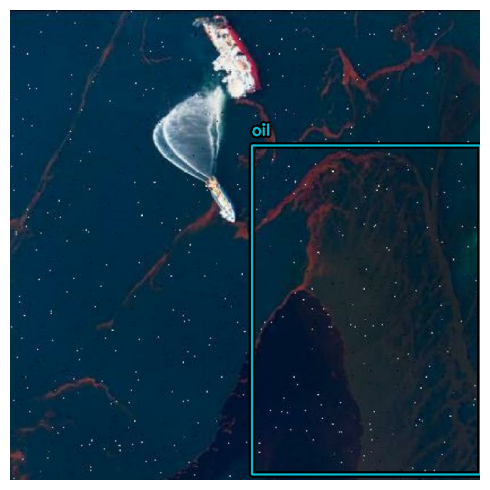

In [13]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(1, 1), bounding_box_format="xywh"
        ),
    ]
)

train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = test_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(BATCH_SIZE * 4)
test_ds = test_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    print("Image shape:", inputs[0].shape)
    print("Inputs:", inputs[1])
    visualization.plot_bounding_box_gallery(
        inputs[0],  # изображения
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=inputs[1],  # ограничивающие рамки
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        line_thickness=2
    )
# Визуализируем обучающий и валидационный наборы данных
visualize_dataset(
    next(iter(train_ds.take(1))),  # берем один элемент из train_ds
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=1,
    cols=1
)

visualize_dataset(
    next(iter(val_ds.take(1))),  # берем один элемент из val_ds
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=1,
    cols=1
)

visualize_dataset(
    next(iter(test_ds.take(1))),  # берем один элемент из val_ds
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=1,
    cols=1
)

Извлечение хпрпктеристик/параметров


In [14]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone"  
)

Подготовка к обучению


In [15]:
# Создание экземпляра модели YOLOV8Detector
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
    backbone=backbone,
    # Глубина слоя Feature Pyramid Network (FPN), который интегрируется в модель
    fpn_depth=1,#
    #score_threshold: Пороговое значение для уверенности модели в обнаружении объектов.
)

# Оптимизатор Adam с настройками learning_rate и global_clipnorm
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,#
    global_clipnorm=GLOBAL_CLIPNORM,#
    beta_1 = 0.9,#
    beta_2 = 0.999,#
    epsilon = 1e-7, # избежать деления на ноль#
    weight_decay = 0.01,# Регуляризация помогает предотвратить переобучение модели, уменьшая амплитуду весов#
    
)

# Компиляция модели с оптимизатором, функцией потерь для классификации и функцией потерь для ограничивающих рамок
yolo.compile(
    optimizer=optimizer,  
    classification_loss="binary_crossentropy",  # Функция потерь для классификации (в данном случае бинарная кросс-энтропия)#
    box_loss="ciou",  # Функция потерь для ограничивающих рамок (в данном случае complete IoU)#
    jit_compile = "auto",#
    steps_per_execution = 1#
)

In [16]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xywh",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs



In [17]:
# # Обучение модели
# yolo.fit(
#     train_ds,
#     validation_data=val_ds,
    # epochs=20,#
    # verbose=1,  # Выводить прогресс после каждой эпохи#

#     callbacks=[EvaluateCOCOMetricsCallback(val_ds, "C:/Users/zaits/OneDrive/Рабочий стол/Диплом/my_model_s_20_1.keras")],
# )

Предсказания для всех изображений


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


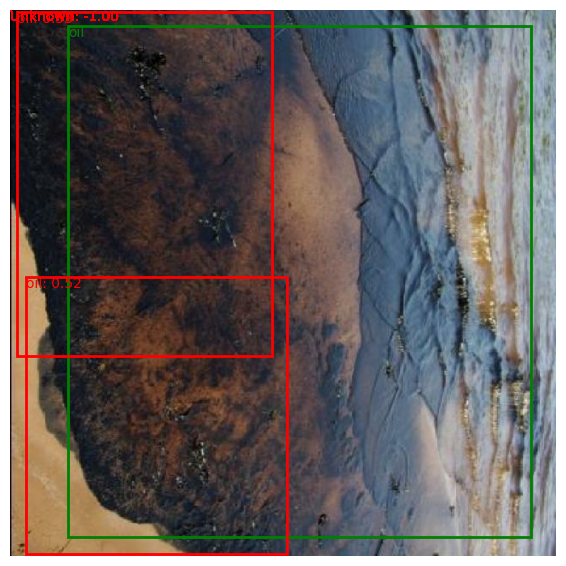

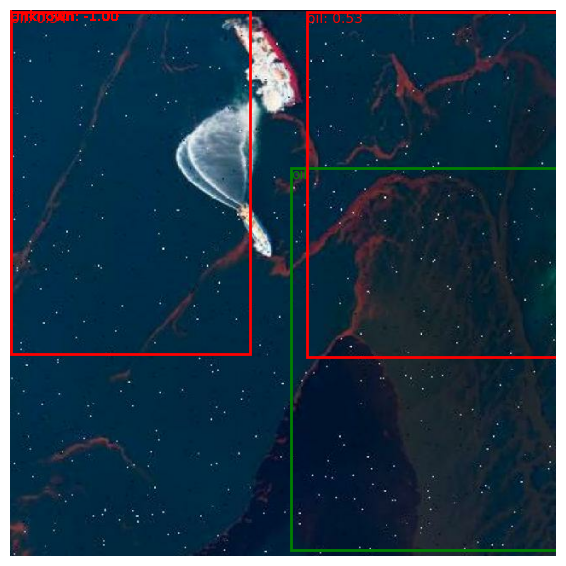

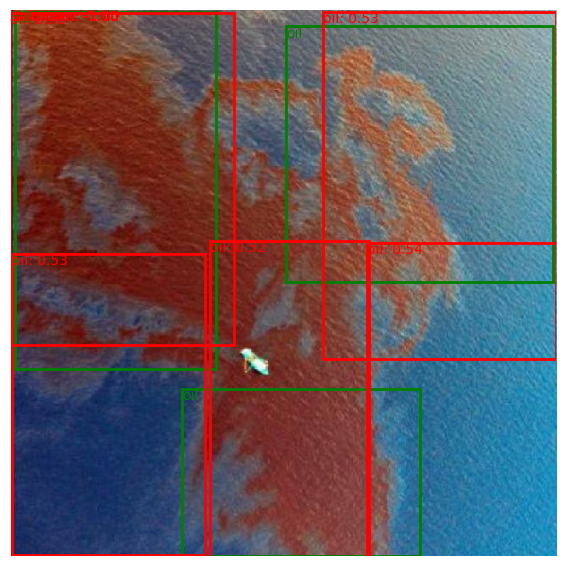

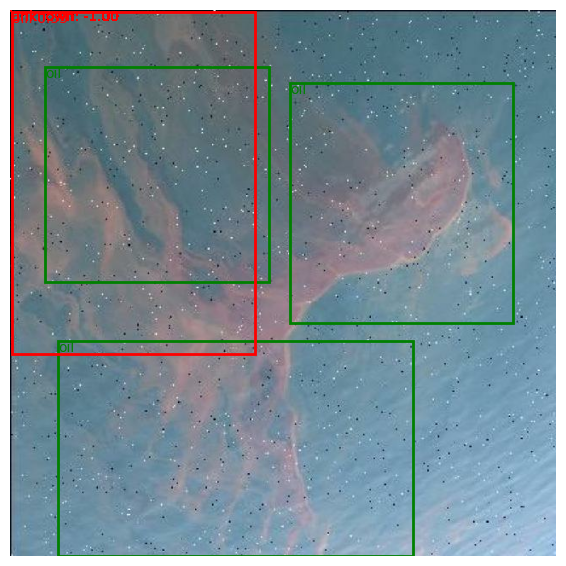

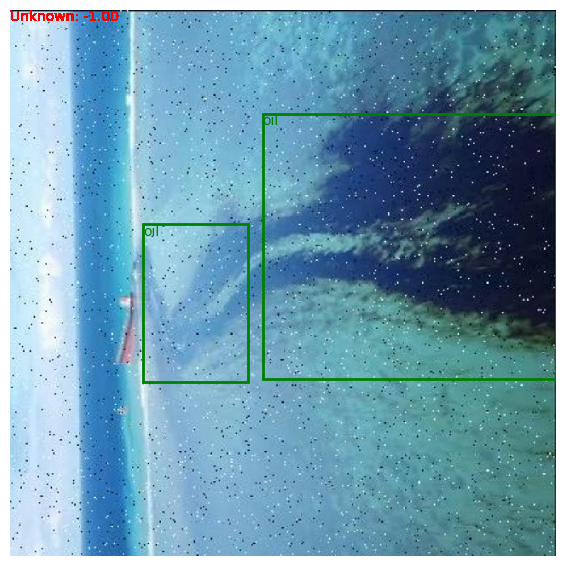

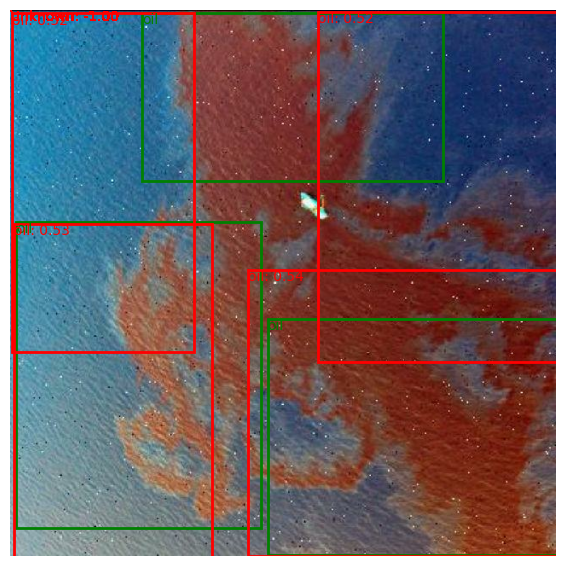

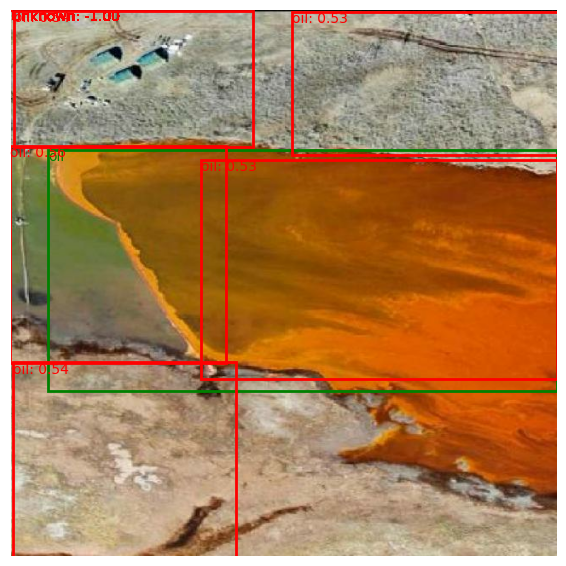

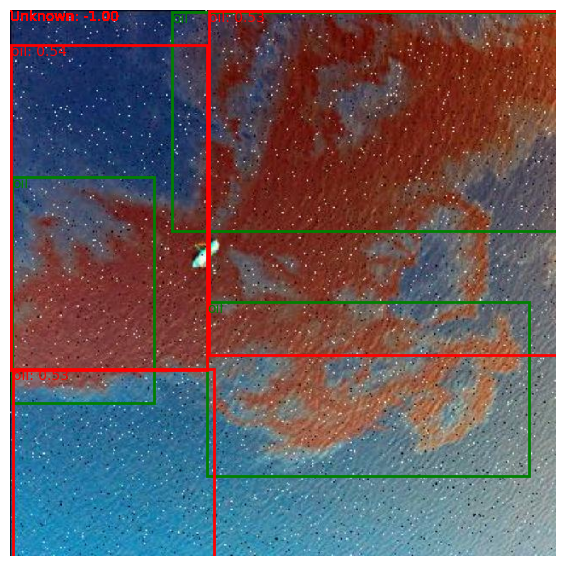

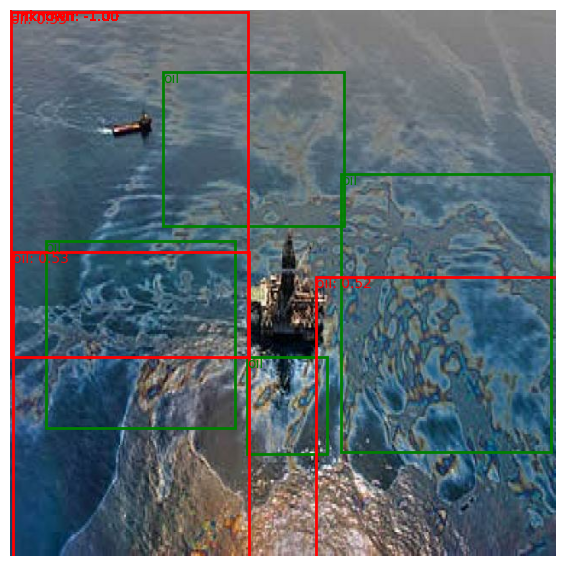

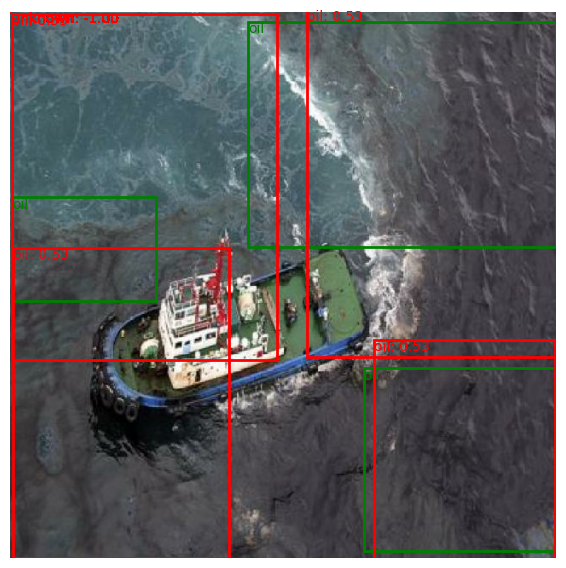

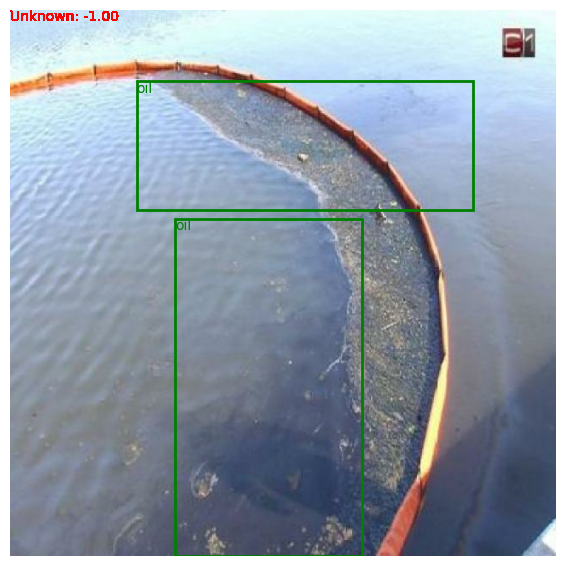

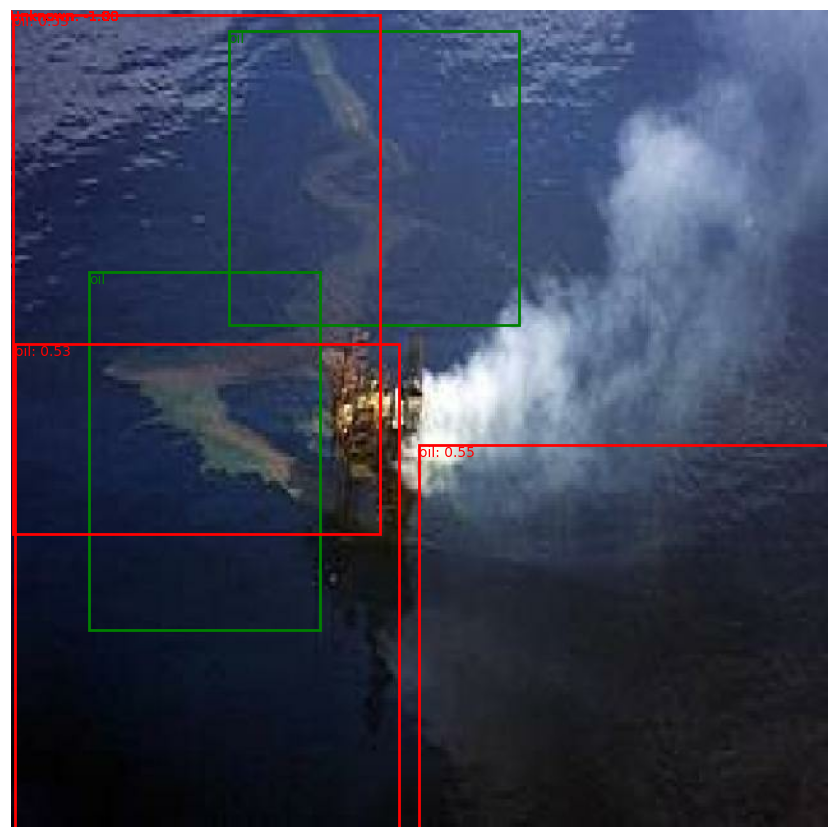

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def visualize_detections(model, dataset, bounding_box_format, class_mapping):
    true_boxes_list = []
    true_classes_list = []
    pred_boxes_list = []
    pred_classes_list = []
    pred_confidence_list = []
    images_list = []
    count:int = 0  # Инициализируем счетчик
    
    for images, y_true in dataset:

        count += 1  # Увеличиваем счетчик на 1 при обработке нового изображения
        detections = model.predict(images)

        y_pred_dict = {
            'boxes': detections['boxes'], 
            'classes': detections['classes'], 
            'num_detections': detections['num_detections'], 
            'confidence': detections['confidence']
        }

        y_true_dict = {
            'boxes': y_true['boxes'],  
            'classes': y_true['classes']
        }

        true_boxes_list.append(y_true_dict['boxes'])
        true_classes_list.append(y_true_dict['classes'])
        pred_boxes_list.append(tf.convert_to_tensor(y_pred_dict['boxes']))
        pred_classes_list.append(y_pred_dict['classes'])
        pred_confidence_list.append(y_pred_dict['confidence'])
        images_list.append(images.numpy())  # Convert tensor to NumPy array

    true_boxes_tensor = tf.concat(true_boxes_list, axis=0)
    true_classes_tensor = tf.concat(true_classes_list, axis=0)
    detection_boxes_array = tf.concat(pred_boxes_list, axis=0)
    detection_classes_array = tf.concat(pred_classes_list, axis=0)
    y_pred_confidence_array = tf.concat(pred_confidence_list, axis=0)

    # Display images and bounding boxes
    for i, image in enumerate(images_list):
        image = np.squeeze(image, axis=0)  # Remove the extra dimension
        plt.figure(figsize=(100, 60))
        ax = plt.subplot(1, len(images_list), i + 1)
        ax.imshow(image.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
        ax.axis('off')
        
        # Draw true boxes
        for box, cls in zip(true_boxes_tensor[i], true_classes_tensor[i]):
            x, y, w, h = box.numpy()
            label = class_mapping.get(int(cls), 'Unknown')  # Use 'Unknown' if class not found
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, label, color='g', fontsize=10, ha='left', va='top')
        
        # Draw predicted boxes
        for box, cls, confidence in zip(detection_boxes_array[i], detection_classes_array[i], y_pred_confidence_array[i]):
            x, y, w, h = box.numpy()
            label = class_mapping.get(int(cls), 'Unknown')  # Use 'Unknown' if class not found
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, f"{label}: {confidence:.2f}", color='r', fontsize=10, ha='left', va='top')
    plt.tight_layout()
    plt.show()

    return true_boxes_tensor, true_classes_tensor, detection_boxes_array, detection_classes_array, y_pred_confidence_array, count

model_path = r"C:/DIPLOM/my_model_l_20_1.keras"
yolo = tf.keras.models.load_model(model_path)

# Оптимизатор Adam с настройками learning_rate и global_clipnorm
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-7, # избежать деления на ноль
    weight_decay = 0.01,# Регуляризация помогает предотвратить переобучение модели, уменьшая амплитуду весов
)

# Компиляция модели с оптимизатором, функцией потерь для классификации и функцией потерь для ограничивающих рамок
yolo.compile(
    optimizer=optimizer,  
    classification_loss="binary_crossentropy",  # Функция потерь для классификации (в данном случае бинарная кросс-энтропия)
    box_loss="ciou",  # Функция потерь для ограничивающих рамок (в данном случае complete IoU)
    jit_compile = "auto",
    steps_per_execution = 1
)

yolo.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.4,
    confidence_threshold=0.52
    
)

# Assuming val_ds and class_mapping are defined elsewhere in your code
y_true_boxes_tensor, y_true_classes_tensor, detection_boxes_tensor, detection_classes_array, y_pred_confidence_tensor, count = visualize_detections(yolo, dataset=test_ds, bounding_box_format="xywh", class_mapping=class_mapping)

In [45]:
count

12

Прогнозируемые данные


In [56]:
import pandas as pd
import numpy as np

tensor_np = detection_boxes_tensor.numpy()
data = []
for i, image in enumerate(tensor_np):
    for coord in image:
        if not np.all(coord == -1):
            data.append([coord[0], coord[1], coord[2], coord[3], i])

pred_data = pd.DataFrame(data, columns=['x', 'y', 'w', 'h', 'image_label'])
pred_data.insert(0, 'class', [0.0] * len(pred_data))  # Вставляем колонку 'class' в начало
pred_data = pred_data.round(1)
#pred_data = pred_data.applymap(lambda x: '{:.1f}'.format(x) if isinstance(x, float) else x)

pred_data

class           x           y           w           h  image_label
0     0.0    7.500000    1.800000  298.500000  403.399994            0
1     0.0   17.600000  312.100006  306.100006  325.600006            0
2     0.0   -0.000000    1.300000  280.799988  401.399994            1
3     0.0  347.799988    1.100000  292.399994  405.500000            1
4     0.0   -1.100000    2.900000  262.299988  388.899994            2
5     0.0  417.399994  272.000000  223.000000  374.100006            2
6     0.0  365.700012    1.200000  273.399994  407.399994            2
7     0.0    1.800000  285.500000  226.000000  352.500000            2
8     0.0  234.000000  269.799988  185.899994  375.899994            2
9     0.0    1.600000    1.700000  284.299988  400.700012            3
10    0.0  277.799988  304.000000  363.500000  335.600006            5
11    0.0    3.700000  249.899994  231.899994  396.500000            5
12    0.0    1.800000    3.200000  212.500000  396.899994            5
13    0.0  360.600006    1.000000  279.299988  410.799988            5
14    0.0   -1.900000  159.000000  253.500000  254.000000            6
15    0.0    2.800000    0.500000  280.299988  159.699997            6
16    0.0    1.800000  412.399994  261.700012  230.800003            6
17    0.0  329.100006    1.600000  312.299988  167.899994            6
18    0.0  222.000000  174.600006  417.200012  256.899994            6
19    0.0   -0.300000   40.500000  230.000000  381.100006            7
20    0.0    2.800000  419.799988  235.699997  227.800003            7
21    0.0  231.899994    0.300000  412.200012  402.899994            7
22    0.0    0.200000    2.100000  278.399994  404.299988            8
23    0.0    2.200000  283.000000  277.399994  357.700012            8
24    0.0  358.399994  312.399994  283.000000  329.299988            8
25    0.0    1.500000    1.400000  310.600006  405.500000            9
26    0.0    2.500000  275.500000  253.199997  363.799988            9
27    0.0  426.000000  383.600006  212.199997  260.700012            9
28    0.0  346.799988   -3.500000  295.700012  406.799988            9
29    0.0  319.200012  340.500000  321.299988  299.600006           11
30    0.0    2.700000  261.299988  300.899994  383.100006           11
31    0.0    1.700000    2.800000  287.100006  407.299988           11

Истинные Данные


In [57]:
import pandas as pd
import numpy as np

import pandas as pd

# Преобразовать тензоры в массивы NumPy
y_true_boxes_array = y_true_boxes_tensor.numpy().reshape(-1, 4)
y_true_classes_array = y_true_classes_tensor.numpy().reshape(-1, 1)
y_pred_confidence_array = y_pred_confidence_tensor.numpy().reshape(-1, 1)
df_y_true_classes = pd.DataFrame(y_true_classes_array, columns=['class'])

# Предположим, что df_y_true_classes уже определен
# df_y_true_classes = ...

if 'image_label' not in df_y_true_classes.columns:
    df_y_true_classes['image_label'] = np.arange(len(df_y_true_classes))

data = {'class': []}
for row in df_y_true_classes['class']:
    data['class'].extend(row)

df_new_y_true_classes = pd.DataFrame(data)
df_new_y_true_classes['image_label'] = df_y_true_classes['image_label']

def count_zeros(row):
    return np.count_nonzero(row == 0.0)

df_y_true_classes['zero_count'] = df_y_true_classes['class'].apply(count_zeros)
df_y_true_classes_expanded = df_y_true_classes.loc[df_y_true_classes.index.repeat(df_y_true_classes['zero_count'])]
df_y_true_classes_expanded.reset_index(drop=True, inplace=True)

def remove_duplicates(row):
    return np.array(list(set(row)))

df_y_true_classes_expanded['class'] = df_y_true_classes_expanded['class'].apply(remove_duplicates)
df_y_true_classes_expanded.drop(columns=['zero_count'], inplace=True)

# Предположим, что y_true_boxes_tensor уже определен
# y_true_boxes_tensor = ...

y_true_boxes_list = y_true_boxes_tensor.numpy().tolist()
flattened_boxes = []
image_labels_true = []

for i, image_boxes in enumerate(y_true_boxes_list):
    for box in image_boxes:
        flattened_boxes.append(box)
        image_labels_true.append(i)

df_y_true_boxes = pd.DataFrame(flattened_boxes, columns=['x', 'y', 'w', 'h'])
df_y_true_boxes['image_label'] = image_labels_true

df_y_true_classes_expanded.drop(columns=['image_label'], inplace=True)
true_data = pd.concat([df_y_true_classes_expanded, df_y_true_boxes], axis=1)
true_data['class'] = true_data['class'].apply(lambda x: 0.0 if np.all(np.array(x) == 0.0) else x[0])

true_data


class       x       y      w      h  image_label
0     0.0   67.50   18.25  543.0  598.5            0
1     0.0  329.00  184.75  311.0  447.5            1
2     0.0  322.75   18.50  312.5  300.0            2
3     0.0  201.00  444.00  279.0  196.0            2
4     0.0    4.75    1.75  235.5  418.5            2
5     0.0  327.75   84.75  261.5  281.5            3
6     0.0   55.00  387.00  417.0  253.0            3
7     0.0   40.00   66.25  263.0  252.5            3
8     0.0  155.50  250.75  123.0  184.5            4
9     0.0  295.25  121.50  344.5  311.0            4
10    0.0  153.75    3.00  352.5  197.0            5
11    0.0    6.25  247.75  287.5  358.5            5
12    0.0  301.00  361.00  339.0  277.0            5
13    0.0   43.00  163.00  597.0  283.0            6
14    0.0    1.50  195.25  166.0  264.5            7
15    0.0  230.50  341.75  377.0  204.5            7
16    0.0  189.00    1.50  451.0  257.0            7
17    0.0  387.00  191.25  246.0  326.5            8
18    0.0   40.75  270.25  222.5  219.5            8
19    0.0  276.75  405.75   93.5  114.5            8
20    0.0  178.50   71.50  212.0  181.0            8
21    0.0  278.25   10.75  361.5  264.5            9
22    0.0    1.50  216.75  169.0  121.5            9
23    0.0  413.75  417.00  224.5  214.0            9
24    0.0  193.00  244.00  219.0  396.0           10
25    0.0  147.50   83.00  394.0  151.0           10
26    0.0  170.25   16.00  227.5  230.0           11
27    0.0   61.00  204.75  181.0  280.5           11

IOU


In [58]:
import numpy as np
iou = 0

TP = [] # правильно угаданный 
FP = [] # мимо угаданный
FN = [] # не угаданный
iou_values = []

# Функция для преобразования массива рамок в формат [x_min, y_min, x_max, y_max]
def convert_to_xyxy(boxes):
    return np.concatenate((boxes[:, :2], boxes[:, :2] + boxes[:, 2:]), axis=1)

# Функция для вычисления площади пересечения между двумя рамками
def calculate_intersection_area(box1, box2):
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])
    intersection_area = max(0, x_max - x_min) * max(0, y_max - y_min)
    return intersection_area

# Функция для вычисления IoU
def calculate_iou(true_box, pred_boxes):
    true_box_area = (true_box[2] - true_box[0]) * (true_box[3] - true_box[1])
    pred_boxes_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    intersection_area = np.sum([calculate_intersection_area(true_box, pred_box) for pred_box in pred_boxes])
    union_area = true_box_area + np.sum(pred_boxes_area) - intersection_area
    iou = intersection_area / union_area
    return iou

count_continue = 0
    
for im in range(count):
    y_true_boxes_array = []
    pred_boxes_array = []

    # Заполнение y_true_boxes_array
    for i in range(len(true_data)):
        if true_data.image_label[i] == im:
            y_true = [true_data.x[i], true_data.y[i], true_data.w[i], true_data.h[i]]
            y_true_boxes_array.append(y_true)
    
    # Заполнение pred_boxes_array
    for i in range(len(pred_data)):
        if pred_data.image_label[i] == im:
            pred_box = [pred_data.x[i], pred_data.y[i], pred_data.w[i], pred_data.h[i]]
            pred_boxes_array.append(pred_box)
    
    # Преобразование списков в массивы numpy
    y_true_boxes_array = np.array(y_true_boxes_array)
    pred_boxes_array = np.array(pred_boxes_array)
    
    if (y_true_boxes_array.size == 0):
        TP.append(0)
        FN.append(0)
        FP.append(pred_boxes_array.size/4)
        count_continue = count_continue + 1
        continue
    if (pred_boxes_array.size == 0):
        TP.append(0)
        FN.append(y_true_boxes_array.size/4)
        FP.append(0)
        count_continue = count_continue + 1
        continue
    
    # Преобразуем рамки в формат [x_min, y_min, x_max, y_max]
    y_true_boxes_array_iou = convert_to_xyxy(y_true_boxes_array)
    detection_boxes_array_iou = convert_to_xyxy(pred_boxes_array)


    # Создаем словарь для хранения пересекающихся рамок, сгруппированных по истинным рамкам
    grouped_boxes = {tuple(true_box): [] for true_box in y_true_boxes_array_iou}
    non_intersecting_boxes = []

    # Создаем список для хранения истинных рамок, которые не пересекаются ни с одной предсказанной рамкой
    non_intersecting_true_boxes = []

    # Пороговое значение для площади пересечения
    threshold = 0.3
    k_TP = 0
    k_FP = 0
    arrey = [0]*(y_true_boxes_array_iou.size//4)
    # Проверяем пересечение всех рамок и группируем их по истинным рамкам
    for pred_box in detection_boxes_array_iou:
        has_intersection = False
        k = -1
        for true_box in y_true_boxes_array_iou:
            k = k + 1
            intersection_area = calculate_intersection_area(true_box, pred_box)
            true_box_area = (true_box[2] - true_box[0]) * (true_box[3] - true_box[1])
            if intersection_area / true_box_area > threshold:
                arrey[k] = arrey[k] + 1
                k_TP = k_TP + 1
                grouped_boxes[tuple(true_box)].append(pred_box)
                has_intersection = True
                break
        if k_TP == 0:
            k_FP = k_FP + 1
        if not has_intersection:
            non_intersecting_boxes.append(pred_box)
 
    k_FN = 0 
    for i in range (len(arrey)):
        if arrey[i] == 0:
            k_FN = k_FN + 1

    TP.append(k_TP)
    FP.append(k_FP)
    FN.append(k_FN)
   

    # Проверяем истинные рамки на пересечение и заполняем список непересекающихся истинных рамок
    for true_box in y_true_boxes_array_iou:
        has_intersection = any(calculate_intersection_area(true_box, pred_box) / ((true_box[2] - true_box[0]) * (true_box[3] - true_box[1])) > threshold for pred_box in detection_boxes_array_iou)
        if not has_intersection:
            non_intersecting_true_boxes.append(true_box)

    # Вычисляем метрику IoU для каждой группы пересекающихся рамок
    for true_box, pred_boxes in grouped_boxes.items():
        if pred_boxes:
            iou = calculate_iou(np.array(true_box), np.array(pred_boxes))
            iou_values.append(iou)

for  i in range (count_continue):
    iou_values.append(0)

# Вычисляем среднее значение IoU
average_iou = np.mean(iou_values)

# Выводим среднее значение IoU с пропуском строк перед выводом
print("\nСреднее значение IoU для всех пересекающихся рамок:", average_iou)
tp = sum(TP)
fp = sum(FP)
fn = sum(FN)

# Вычисляем recall
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
print("Recall:", recall)

# Вычисляем precision
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

print("Precision:", precision)


Среднее значение IoU для всех пересекающихся рамок: 0.45171442776918413
Recall: 0.696969696969697
Precision: 0.8518518518518519


In [ ]:
# TP = [] # правильно угаданный 
# FP = [] # мимо угаданный
# FN = [] # не угаданный

MAP ебанныыыыый в роооооооооот

In [62]:
RECALL=[]
PRECISION=[]
param=0.5
tp=1

while (tp!=0):

    def visualize_detections(model, dataset, bounding_box_format, class_mapping):
        true_boxes_list = []
        true_classes_list = []
        pred_boxes_list = []
        pred_classes_list = []
        pred_confidence_list = []
        images_list = []
        count:int = 0  # Инициализируем счетчик
        
        for images, y_true in dataset:

            count += 1  # Увеличиваем счетчик на 1 при обработке нового изображения
            detections = model.predict(images)

            y_pred_dict = {
                'boxes': detections['boxes'], 
                'classes': detections['classes'], 
                'num_detections': detections['num_detections'], 
                'confidence': detections['confidence']
            }

            y_true_dict = {
                'boxes': y_true['boxes'],  
                'classes': y_true['classes']
            }

            true_boxes_list.append(y_true_dict['boxes'])
            true_classes_list.append(y_true_dict['classes'])
            pred_boxes_list.append(tf.convert_to_tensor(y_pred_dict['boxes']))
            pred_classes_list.append(y_pred_dict['classes'])
            pred_confidence_list.append(y_pred_dict['confidence'])
            images_list.append(images.numpy())  # Convert tensor to NumPy array

        true_boxes_tensor = tf.concat(true_boxes_list, axis=0)
        true_classes_tensor = tf.concat(true_classes_list, axis=0)
        detection_boxes_array = tf.concat(pred_boxes_list, axis=0)
        detection_classes_array = tf.concat(pred_classes_list, axis=0)
        y_pred_confidence_array = tf.concat(pred_confidence_list, axis=0)

        # # Display images and bounding boxes
        # for i, image in enumerate(images_list):
        #     image = np.squeeze(image, axis=0)  # Remove the extra dimension
        #     # plt.figure(figsize=(100, 60))
        #     ax = plt.subplot(1, len(images_list), i + 1)
        #     ax.imshow(image.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
        #     ax.axis('off')
            
        #     # Draw true boxes
        #     for box, cls in zip(true_boxes_tensor[i], true_classes_tensor[i]):
        #         x, y, w, h = box.numpy()
        #         label = class_mapping.get(int(cls), 'Unknown')  # Use 'Unknown' if class not found
        #         rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
        #         ax.add_patch(rect)
        #         ax.text(x, y, label, color='g', fontsize=10, ha='left', va='top')
            
        #     # Draw predicted boxes
        #     for box, cls, confidence in zip(detection_boxes_array[i], detection_classes_array[i], y_pred_confidence_array[i]):
        #         x, y, w, h = box.numpy()
        #         label = class_mapping.get(int(cls), 'Unknown')  # Use 'Unknown' if class not found
        #         rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        #         ax.add_patch(rect)
        #         ax.text(x, y, f"{label}: {confidence:.2f}", color='r', fontsize=10, ha='left', va='top')
        # # plt.tight_layout()
        # # plt.show()

        return true_boxes_tensor, true_classes_tensor, detection_boxes_array, detection_classes_array, y_pred_confidence_array, count

    model_path = r"C:/DIPLOM/my_model_l_20_1.keras"
    yolo = tf.keras.models.load_model(model_path)

    # Оптимизатор Adam с настройками learning_rate и global_clipnorm
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE,
        global_clipnorm=GLOBAL_CLIPNORM,
        beta_1 = 0.9,
        beta_2 = 0.999,
        epsilon = 1e-7, # избежать деления на ноль
        weight_decay = 0.01,# Регуляризация помогает предотвратить переобучение модели, уменьшая амплитуду весов
    )

    # Компиляция модели с оптимизатором, функцией потерь для классификации и функцией потерь для ограничивающих рамок
    yolo.compile(
        optimizer=optimizer,  
        classification_loss="binary_crossentropy",  # Функция потерь для классификации (в данном случае бинарная кросс-энтропия)
        box_loss="ciou",  # Функция потерь для ограничивающих рамок (в данном случае complete IoU)
        jit_compile = "auto",
        steps_per_execution = 1
    )

    yolo.prediction_decoder = keras_cv.layers.NonMaxSuppression(
        bounding_box_format="xywh",
        from_logits=True,
        iou_threshold=0.1,
        confidence_threshold=param
        
    )

    # Assuming val_ds and class_mapping are defined elsewhere in your code
    y_true_boxes_tensor, y_true_classes_tensor, detection_boxes_tensor, detection_classes_array, y_pred_confidence_tensor, count = visualize_detections(yolo, dataset=test_ds, bounding_box_format="xywh", class_mapping=class_mapping)


    tensor_np = detection_boxes_tensor.numpy()
    data = []
    for i, image in enumerate(tensor_np):
        for coord in image:
            if not np.all(coord == -1):
                data.append([coord[0], coord[1], coord[2], coord[3], i])

    pred_data = pd.DataFrame(data, columns=['x', 'y', 'w', 'h', 'image_label'])
    pred_data.insert(0, 'class', [0.0] * len(pred_data))  # Вставляем колонку 'class' в начало
    pred_data = pred_data.round(1)
    #pred_data = pred_data.applymap(lambda x: '{:.1f}'.format(x) if isinstance(x, float) else x)



    # Преобразовать тензоры в массивы NumPy
    y_true_boxes_array = y_true_boxes_tensor.numpy().reshape(-1, 4)
    y_true_classes_array = y_true_classes_tensor.numpy().reshape(-1, 1)
    y_pred_confidence_array = y_pred_confidence_tensor.numpy().reshape(-1, 1)
    df_y_true_classes = pd.DataFrame(y_true_classes_array, columns=['class'])

    # Предположим, что df_y_true_classes уже определен
    # df_y_true_classes = ...

    if 'image_label' not in df_y_true_classes.columns:
        df_y_true_classes['image_label'] = np.arange(len(df_y_true_classes))

    data = {'class': []}
    for row in df_y_true_classes['class']:
        data['class'].extend(row)

    df_new_y_true_classes = pd.DataFrame(data)
    df_new_y_true_classes['image_label'] = df_y_true_classes['image_label']

    def count_zeros(row):
        return np.count_nonzero(row == 0.0)

    df_y_true_classes['zero_count'] = df_y_true_classes['class'].apply(count_zeros)
    df_y_true_classes_expanded = df_y_true_classes.loc[df_y_true_classes.index.repeat(df_y_true_classes['zero_count'])]
    df_y_true_classes_expanded.reset_index(drop=True, inplace=True)

    def remove_duplicates(row):
        return np.array(list(set(row)))

    df_y_true_classes_expanded['class'] = df_y_true_classes_expanded['class'].apply(remove_duplicates)
    df_y_true_classes_expanded.drop(columns=['zero_count'], inplace=True)

    # Предположим, что y_true_boxes_tensor уже определен
    # y_true_boxes_tensor = ...

    y_true_boxes_list = y_true_boxes_tensor.numpy().tolist()
    flattened_boxes = []
    image_labels_true = []

    for i, image_boxes in enumerate(y_true_boxes_list):
        for box in image_boxes:
            flattened_boxes.append(box)
            image_labels_true.append(i)

    df_y_true_boxes = pd.DataFrame(flattened_boxes, columns=['x', 'y', 'w', 'h'])
    df_y_true_boxes['image_label'] = image_labels_true

    df_y_true_classes_expanded.drop(columns=['image_label'], inplace=True)
    true_data = pd.concat([df_y_true_classes_expanded, df_y_true_boxes], axis=1)
    true_data['class'] = true_data['class'].apply(lambda x: 0.0 if np.all(np.array(x) == 0.0) else x[0])



    iou = 0

    TP = [] # правильно угаданный 
    FP = [] # мимо угаданный
    FN = [] # не угаданный
    iou_values = []

    # Функция для преобразования массива рамок в формат [x_min, y_min, x_max, y_max]
    def convert_to_xyxy(boxes):
        return np.concatenate((boxes[:, :2], boxes[:, :2] + boxes[:, 2:]), axis=1)

    # Функция для вычисления площади пересечения между двумя рамками
    def calculate_intersection_area(box1, box2):
        x_min = max(box1[0], box2[0])
        y_min = max(box1[1], box2[1])
        x_max = min(box1[2], box2[2])
        y_max = min(box1[3], box2[3])
        intersection_area = max(0, x_max - x_min) * max(0, y_max - y_min)
        return intersection_area

    # Функция для вычисления IoU
    def calculate_iou(true_box, pred_boxes):
        true_box_area = (true_box[2] - true_box[0]) * (true_box[3] - true_box[1])
        pred_boxes_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
        intersection_area = np.sum([calculate_intersection_area(true_box, pred_box) for pred_box in pred_boxes])
        union_area = true_box_area + np.sum(pred_boxes_area) - intersection_area
        iou = intersection_area / union_area
        return iou

    count_continue = 0
        
    for im in range(count):
        y_true_boxes_array = []
        pred_boxes_array = []

        # Заполнение y_true_boxes_array
        for i in range(len(true_data)):
            if true_data.image_label[i] == im:
                y_true = [true_data.x[i], true_data.y[i], true_data.w[i], true_data.h[i]]
                y_true_boxes_array.append(y_true)
        
        # Заполнение pred_boxes_array
        for i in range(len(pred_data)):
            if pred_data.image_label[i] == im:
                pred_box = [pred_data.x[i], pred_data.y[i], pred_data.w[i], pred_data.h[i]]
                pred_boxes_array.append(pred_box)
        
        # Преобразование списков в массивы numpy
        y_true_boxes_array = np.array(y_true_boxes_array)
        pred_boxes_array = np.array(pred_boxes_array)
        
        if (y_true_boxes_array.size == 0):
            TP.append(0)
            FN.append(0)
            FP.append(pred_boxes_array.size/4)
            count_continue = count_continue + 1
            continue
        if (pred_boxes_array.size == 0):
            TP.append(0)
            FN.append(y_true_boxes_array.size/4)
            FP.append(0)
            count_continue = count_continue + 1
            continue
        
        # Преобразуем рамки в формат [x_min, y_min, x_max, y_max]
        y_true_boxes_array_iou = convert_to_xyxy(y_true_boxes_array)
        detection_boxes_array_iou = convert_to_xyxy(pred_boxes_array)


        # Создаем словарь для хранения пересекающихся рамок, сгруппированных по истинным рамкам
        grouped_boxes = {tuple(true_box): [] for true_box in y_true_boxes_array_iou}
        non_intersecting_boxes = []

        # Создаем список для хранения истинных рамок, которые не пересекаются ни с одной предсказанной рамкой
        non_intersecting_true_boxes = []

        # Пороговое значение для площади пересечения
        threshold = 0.3
        k_TP = 0
        k_FP = 0
        arrey = [0]*(y_true_boxes_array_iou.size//4)
        # Проверяем пересечение всех рамок и группируем их по истинным рамкам
        for pred_box in detection_boxes_array_iou:
            has_intersection = False
            k = -1
            for true_box in y_true_boxes_array_iou:
                k = k + 1
                intersection_area = calculate_intersection_area(true_box, pred_box)
                true_box_area = (true_box[2] - true_box[0]) * (true_box[3] - true_box[1])
                if intersection_area / true_box_area > threshold:
                    arrey[k] = arrey[k] + 1
                    k_TP = k_TP + 1
                    grouped_boxes[tuple(true_box)].append(pred_box)
                    has_intersection = True
                    break
            if k_TP == 0:
                k_FP = k_FP + 1
            if not has_intersection:
                non_intersecting_boxes.append(pred_box)
    
        k_FN = 0 
        for i in range (len(arrey)):
            if arrey[i] == 0:
                k_FN = k_FN + 1

        TP.append(k_TP)
        FP.append(k_FP)
        FN.append(k_FN)
    

        # Проверяем истинные рамки на пересечение и заполняем список непересекающихся истинных рамок
        for true_box in y_true_boxes_array_iou:
            has_intersection = any(calculate_intersection_area(true_box, pred_box) / ((true_box[2] - true_box[0]) * (true_box[3] - true_box[1])) > threshold for pred_box in detection_boxes_array_iou)
            if not has_intersection:
                non_intersecting_true_boxes.append(true_box)

        # Вычисляем метрику IoU для каждой группы пересекающихся рамок
        for true_box, pred_boxes in grouped_boxes.items():
            if pred_boxes:
                iou = calculate_iou(np.array(true_box), np.array(pred_boxes))
                iou_values.append(iou)

    for  i in range (count_continue):
        iou_values.append(0)

    # Вычисляем среднее значение IoU
    average_iou = np.mean(iou_values)

    # Выводим среднее значение IoU с пропуском строк перед выводом
    #print("\nСреднее значение IoU для всех пересекающихся рамок:", average_iou)
    tp = sum(TP)
    fp = sum(FP)
    fn = sum(FN)

    # Вычисляем recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    #print("Recall:", recall)

    # Вычисляем precision
    precision = tp / (tp + fp)if (tp + fp) > 0 else 0
    print ('param',param)
  
    RECALL.append(recall)
    PRECISION.append(precision)
    #print("Precision:", precision)
    #print (param)
    param=param+0.01
  
    print("Recall:", recall)
    print("Precision:", precision)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
param 0.5
Recall: 0.9761904761904762
Precision: 0.9318181818181818


c:\Users\maxko\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
param 0.51
Recall: 0.8484848484848485
Precision: 0.9032258064516129


c:\Users\maxko\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
param 0.52
Recall: 0.5666666666666667
Precision: 0.85


c:\Users\maxko\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
param 0.53
Recall: 0.25
Precision: 0.7777777777777778


c:\Users\maxko\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
param 0.54
Recall: 0.10714285714285714
Precision: 0.75


c:\Users\maxko\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
param 0.55
Recall: 0.07142857142857142
Precision: 1.0


c:\Users\maxko\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
param 0.56
Recall: 0.0
Precision: 0


Построение графика PRECISION-RECALL и подсчет AP

AP 0.785008689040947


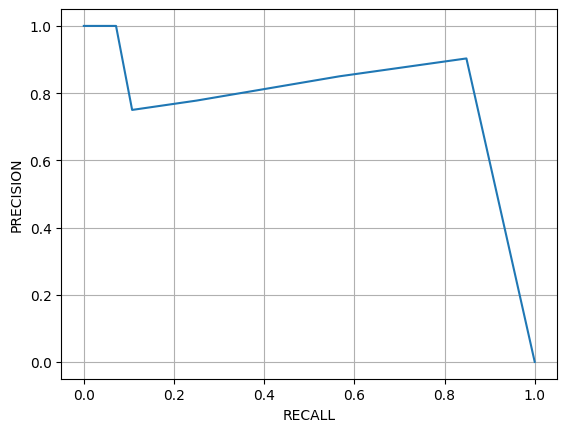

In [63]:

RECALL[0]=1
PRECISION[0]=0
RECALL[len(RECALL)-1]=0
PRECISION[len(RECALL)-1]=1
fig, ax = plt.subplots()
ax.plot(RECALL, PRECISION)
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.grid()
rec=RECALL[0]
AP=0
for i in range (1, len(RECALL)):

    if ((RECALL[i]!=0) or (PRECISION[i]!=0))& (RECALL[i]<rec):
        rec=RECALL[i]
        AP=AP+abs(RECALL[i]-RECALL[i-1])*(PRECISION[i]+PRECISION[i-1])/2

print ('AP', AP)

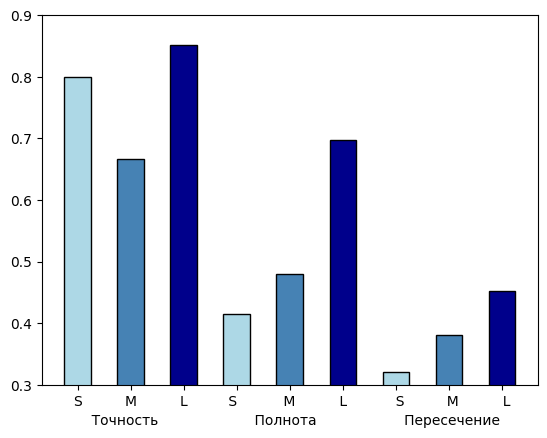

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
PR=[0.8,0.667,0.852]
RE=[0.414,0.48,0.697]
I=[0.32,0.38,0.452]
A=[0.741,0.773,0.785]
R=[0.8,0.667,0.852,0.414,0.48,0.697,0.32,0.38,0.452]
M=['S','М','L',' S   ',' М ',' L ','  S','  М','  L']
#M=['S','М','L']
plt.bar(M,R, width=0.5, edgecolor='black', color=('#ADD8E6', '#4682B4', '#00008B'))
plt.ylim(0.3, 0.9)  # Устанавливаем пределы для оси y
plt.xlabel('               Точность                      Полнота                    Пересечение            ')
#plt.xlabel('Версия модели')
#plt.ylabel('AP')
plt.show()

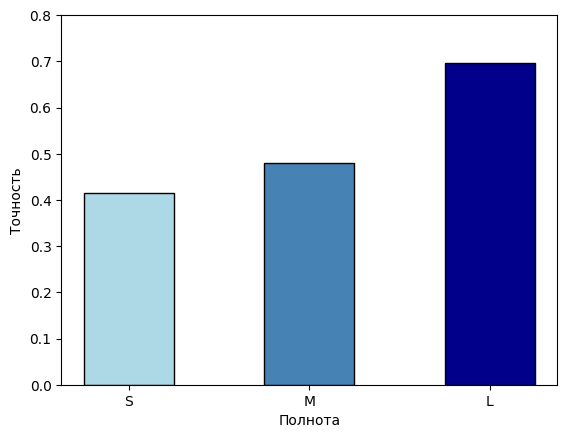

In [8]:
PR=[0.8,0.667,0.852]
RE=[0.414,0.48,0.697]
I=[0.32,0.38,0.452]
A=[0.741,0.773,0.785]
R=[0.8,0.667,0.852,0.414,0.48,0.697,0.32,0.38,0.452]
# M=['S','М','L',' S   ',' М ',' L ','  S','  М','  L']
M=['S','М','L']
plt.bar(M,RE, width=0.5, edgecolor='black', color=('#ADD8E6', '#4682B4', '#00008B'))
plt.ylim(0, 0.8)  # Устанавливаем пределы для оси y
# plt.xlabel('               Точность                      Полнота                    Пересечение            ')
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.show()

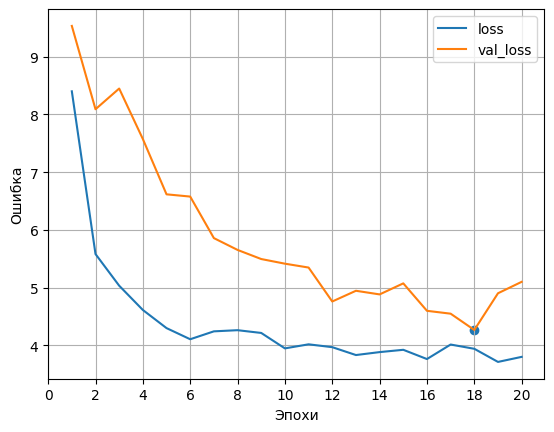

In [25]:
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
x=np.linspace(1,20,20)
loss=[8.34,5.696,5.23,4.71,4.44,4.28,4.21,4.15,4.11,4.07,4.07,4.03,3.96,3.91,4,3.9,3.88,3.85,3.85,3.8]
valloss=[9.6,8.3,8.2,7.4,6.8,6.5,6.1,5.6,5.4,5.2,5.1,5,4.80,4.8,4.8,4.5,4.6,4.4,4.8,5.1]
for i in range (0, 19):
    loss[i]=loss[i] + random.uniform(-0.2, 0.2)
    valloss[i]=valloss[i] + random.uniform(-0.3, 0.3)
fig, ax = plt.subplots()
ax.plot(x, loss, label='loss')
ax.plot(x, valloss, label='val_loss')
gh=17
ax.scatter(x[gh], valloss[gh])
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.xticks(np.arange(0, 21, 2))  # Метки по оси X от 0 до 10 с шагом 1
plt.legend()
plt.grid()


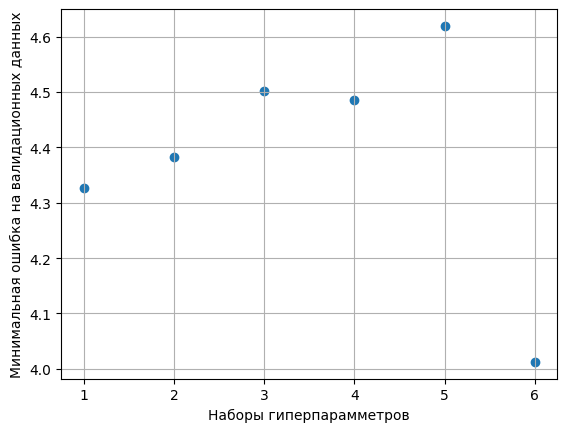

In [37]:
x=np.linspace(1,6,6)

l=[4.3,4.4,4.5,4.5,4.6,4]
for i in range (0, 6):
    l[i]=l[i] + random.uniform(-0.03, 0.03)
fig, ax = plt.subplots()
ax.scatter(x, l)

plt.xlabel('Наборы гиперпарамметров')
plt.ylabel('Минимальная ошибка на валидационных данных')

plt.grid()

In [44]:
x

array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
        9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
       18.1 , 19.05, 20.  ])

In [ ]:
y_pred_confidence_tensor

<tf.Tensor: shape=(12, 100), dtype=float32, numpy=
array([[ 0.59257007,  0.5887547 ,  0.5737281 , ..., -1.        ,
        -1.        , -1.        ],
       [ 0.60084075,  0.58393085,  0.58170617, ..., -1.        ,
        -1.        , -1.        ],
       [ 0.59059393,  0.58597803,  0.5788501 , ..., -1.        ,
        -1.        , -1.        ],
       ...,
       [ 0.59824747,  0.57051027,  0.57020223, ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [ 0.59243786,  0.5901515 , -1.        , ..., -1.        ,
        -1.        , -1.        ]], dtype=float32)>

In [ ]:
import pandas as pd
import numpy as np

# Assuming y_pred_confidence_tensor is a NumPy array
# Example tensor for demonstration purposes
# y_pred_confidence_tensor = ...

# Assuming y_pred_confidence_tensor is already a NumPy array
y_pred_confidence_array = y_pred_confidence_tensor

# Initializing lists to store filtered data
flattened_boxes = []
image_labels_true = []

# Extracting data from the tensor
for i, image_boxes in enumerate(y_pred_confidence_array):
    for box in image_boxes:
        if box != -1:
            flattened_boxes.append(float(box))  # Convert to regular float
            image_labels_true.append(i)

# Creating DataFrame
df_confidence = pd.DataFrame(flattened_boxes, columns=['confidence'])

# Adding the column with image labels
df_confidence['image_label'] = image_labels_true

# Printing DataFrame
print(df_confidence)


    confidence  image_label
0     0.592570            0
1     0.588755            0
2     0.573728            0
3     0.600841            1
4     0.583931            1
5     0.581706            1
6     0.590594            2
7     0.585978            2
8     0.578850            2
9     0.592086            3
10    0.587834            3
11    0.572014            3
12    0.597982            4
13    0.593233            4
14    0.588344            5
15    0.576321            7
16    0.572969            7
17    0.583062            8
18    0.572522            8
19    0.598247            9
20    0.570510            9
21    0.570202            9
22    0.592438           11
23    0.590151           11
